## Making a simple GAN
Using a [video by Aladdin Persson](https://www.youtube.com/watch?v=OljTVUVzPpM) as a guide to creating a Basic GAN which uses the [MNIST](https://deepai.org/dataset/mnist) (A dataset which contains 70,000 images of 28*28 handwritten digits) dataset to train a fully connected GAN to produce images of handwritten digits. I will also be researching PyTorch and why it is widely used as a deep learning framework.

In [ ]:

import torch
import torch.nn as nn # Neural network functionality
import torch.optim as optim # Optimizer function provides different optimizers e.g. Stochastic Gradient Descent, Adam
import torchvision
import torchvision.datasets as datasets # Allows us to download and use different datasets in this case MNIST
from torch.utils.data import DataLoader # Used in training to iterate through the data
import torchvision.transforms as T # Provides a variety of transformations for our data
import matplotlib.pyplot as plt # Used to plot anything
import wandb # Used to log results and save models
wandb.init(project="gans") # Initialise wandb

We import basic PyTorch functions to the program. Looking through the [docs](https://pytorch.org/docs/stable/index.html) gave me a better idea of the specific functions of the program. I researched each import and added comments next to them for clarity. importing packages at the start is like gathering all the cooking ingredients you'll need before you begin cooking - it prepares you with everything required and avoids disruptions later.

In [2]:
class Discriminator(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, img_dim),
            nn.Tanh(),  # normalize inputs to [-1, 1] so make outputs [-1, 1]
        )

    def forward(self, x):
        return self.gen(x)

This code defines two neural networks - a Discriminator and a Generator.

The Discriminator is like a teacher trying to detect forged handwritten numbers. It uses pattern recognition techniques and deep learning. Specifically, it has convolutional layers that act as feature detectors, scanning the input image for shapes and patterns like an eye. It looks at the strokes, curves, sizes etc. to distinguish real from fake. 

The dense layers then act more like the logic and decision making part of the brain, taking what was extracted by the convolutional layers and predicting the probability that the writing is real or forged.

The Generator is like a student trying to carefully forge handwritten numbers. It uses generative modeling techniques to replicate real handwriting. The dense layers act more like imagination, taking random noise and expanding it to forged image dimensions.

The convolutional transpose layers then add in the details, transforming that rough outline into a realistic image with appropriate textures and variations in strokes, size etc.

The forward passes show how each network processes the images/noise through the layered computations to produce the Discriminator's prediction or Generator's forged image output.

By competing against each other, the networks evolve - the Generator gets better at producing convincing forgeries, while the Discriminator gets better at seeing through them. This adversarial process trains the GAN.

In [3]:
# Hyperparameters etc.
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
z_dim = 256
image_dim = 28 * 28 * 1  # 784
batch_size = 30
num_epochs = 10
wandb.log({"lr": lr, "z_dim": z_dim, "image_dim": image_dim, "batch_size": batch_size, "num_epochs": num_epochs})

These variables are what are known as **Hyperparameters**. They are parameters used in the optimizer, the creation of the neural network and the training process. The hyperparamaters in my code include. These parameters are not used inside the neural network:
- ***device*** - Choose which device is used, GPU (cuda) or CPU
- ***lr*** - The **learning rate** also called step size is a paramater for the optimiser which is multiplied by the gradient in the gradient descent algorithm to determine the next point
- ***image_dim*** - Dimensions of the input image or the number of neurons in the first layer of the discriminator
- ***z_dim*** - Dimension of the Latent noise or the number of neurons in the first layer of the generator
- [***batch_size***](https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network#153535) -  The batch size defines the number of samples that will be propagated through the network.

In [4]:
disc = Discriminator(image_dim).to(device)
gen = Generator(z_dim, image_dim).to(device)
fixed_noise = torch.randn((batch_size, z_dim)).to(device)
transforms = T.Compose(
    [T.ToTensor(), T.Normalize((0.5,), (0.5,)),]
)

dataset = datasets.MNIST(root="dataset/", transform=transforms, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()
step = 0

- loads the MNIST dataset of real handwritten digits **dataset**.
- defines a discriminator model **disc** to classify images as real or fake.
- defines a generator model **gen** to create fake images.
- prepares noise **fixed_noise** to pass to the generator.
- gets and prepares the real image data.
- defines optimizers **opt_disc opt_gen** to train the models.
- defines a loss function **criterion** for how well the discriminator classifies.
- initializes a training iteration counter **step**.

In [5]:
disc = torch.compile(disc).to(device)
gen = torch.compile(gen).to(device)

Both disc and gen are compiled for faster training

In [ ]:
fake_img = []
real_img = []

# Training Loop
for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.view(-1, 784).to(device)
        batch_size = real.shape[0]

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise)
        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))W
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad() # 
        lossG.backward()
        opt_gen.step()
        wandb.log(
            {
                "Generator": lossG,
                "Discriminator": lossD,
            }
        )
        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \
                      Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise).reshape(-1, 1, 28, 28)
                data = real.reshape(-1, 1, 28, 28)
                img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                img_grid_real = torchvision.utils.make_grid(data, normalize=True)
                fake_img.append(img_grid_fake)
                real_img.append(img_grid_real)
                wandb.log(
                    {
                        "Mnist Fake Images": [wandb.Image(img_grid_fake)],
                        "Mnist Real Images": [wandb.Image(img_grid_real)],
                    }
                )
                step += 1

- Loop over epochs and batches of real images
- Get a batch of real images, flatten to vectors, send to device
- Get batch size for sampling noise
- Sample random noise for generator
- Run noise through generator to get fake images
- Evaluate discriminator on real images, calculate loss
- Evaluate discriminator on fake images, calculate loss
- Combine discriminator losses, backprop and update discriminator
- Evaluate discriminator on fake images again
- Calculate generator loss to fool discriminator
- Backprop generator loss and update generator
- Log losses to monitor training
- Occasionally print losses and generate fake images
- Save some fake images to visualize generator progress

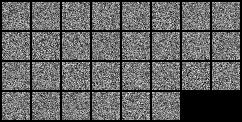

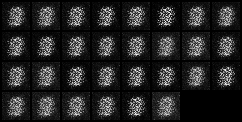

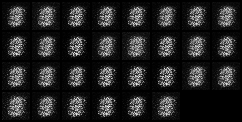

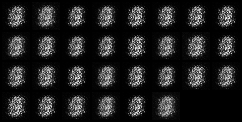

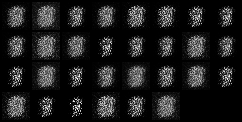

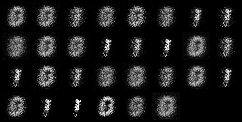

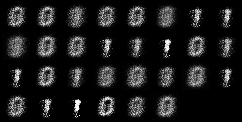

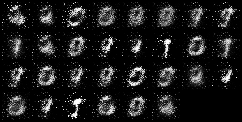

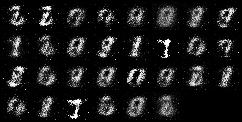

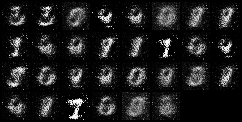

In [21]:
from IPython.display import display
for img in fake_img:
    display(T.functional.to_pil_image(img))

As we can see the results from the GAN barely represents handwritten images, but it can be seen that it is making effort to learn the general structure of numbers

![discriminator loss](Discriminator.png)
![generator loss](Generator.png)

From this graph we can see how the Loss similarly changes throughout training for both the Discriminator and Generator